<h1 style="margin-bottom: 3px;">
  <hr style="border:none; height:3px;">
  <center>PFITZER PROJECT</center>
  <hr style="border:none; height:3px;">
</h1>

<h2 style="text-align:center; margin-top: 3px;">Assigning Sales Representatives to a Territory</h2>

<p><center><strong>Authors:</strong> Abderrahmane DKOUR, Malek BOUHADIDA, Yuxian ZUO</center></p>


# Setup

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# Step 1

## Data

In [26]:
df_distances = pd.read_excel('data/distances.xlsx', sheet_name=0, header=None)
distances = df_distances.iloc[2:, 2:].to_numpy()

In [27]:
print(distances)

[[16.16 24.08 24.32 21.12]
 [19.0 26.47 27.24 17.33]
 [25.29 32.49 33.42 12.25]
 [0.0 7.93 8.31 36.12]
 [3.07 6.44 7.56 37.37]
 [1.22 7.51 8.19 36.29]
 [2.8 10.31 10.95 33.5]
 [2.87 5.07 5.67 38.8]
 [3.8 8.01 7.41 38.16]
 [12.35 4.52 4.35 48.27]
 [11.11 3.48 2.97 47.14]
 [21.99 22.02 24.07 39.86]
 [8.82 3.3 5.36 43.31]
 [7.93 0 2.07 43.75]
 [9.34 2.25 1.11 45.43]
 [8.31 2.07 0.0 44.43]
 [7.31 2.44 1.11 43.43]
 [7.55 0.75 1.53 43.52]
 [11.13 18.41 19.26 25.4]
 [17.49 23.44 24.76 23.21]
 [11.03 18.93 19.28 25.43]
 [36.12 43.75 44.43 0.0]]


In [28]:
df_workloads = pd.read_csv('data/bricks_index_values.csv')
workloads = df_workloads['index_value'].to_numpy()

In [29]:
print(workloads)

[0.1609 0.1164 0.1026 0.1516 0.0939 0.132  0.0687 0.093  0.2116 0.2529
 0.0868 0.0828 0.0975 0.8177 0.4115 0.3795 0.071  0.0427 0.1043 0.0997
 0.1698 0.2531]


In [30]:
# Current assignment (c_ij)
current_assignment = np.zeros((22, 4))
current_assignment[[0, 1, 2, 3, 4], 0] = 1
current_assignment[[5, 6, 7, 8], 1] = 1
current_assignment[[9, 10, 11, 12, 13], 2] = 1
current_assignment[[14, 15, 16, 17, 18, 19, 20, 21], 3] = 1

In [31]:
workload_min = 0.8
workload_max = 1.2

## Two Mono-Objective Linear Optimization Models

### Models:

1. **Distance Minimization**: Minimize the total travel distance for Sales Representatives (SRs).
2. **Disruption Minimization**: Minimize disruption by assigning bricks as close as possible to their current SR assignments.

### Parameters:

Let:

- $I = \{1, 2, \dots, 22\}$: Set of bricks.  
- $J = \{1, 2, 3, 4\}$: Set of Sales Representatives (SRs).  
- $d_{ij}$: Distance between SR $j$'s center brick and brick $i$.  
- $w_i$: Workload index value of brick $i$.  
- $x_{ij}$: Binary decision variable (1 if brick $i$ is assigned to SR $j$, 0 otherwise).  
- $c_{ij}$: Binary parameter (1 if brick $i$ is currently assigned to SR $j$, 0 otherwise).   

### Objectives: 

Distance Minimization:
$$
Z_1 = \min \sum_{i \in I} \sum_{j \in J} d_{ij} \cdot x_{ij}
$$

Disruption Minimization:
$$
Z_2 = \min \sum_{i \in I} \sum_{j \in J} w_i \cdot |x_{ij} - c_{ij}|
$$

where $|x_{ij} - c_{ij}|$ accounts for reassignment.

### Constraints:

1. Each brick is assigned to exactly one SR:  
$$
\sum_{j \in J} x_{ij} = 1, \quad \forall i \in I
$$

2. Workload constraints: e.g., the workload for each SR must be balanced between 0.8 and 1.2:  
$$
0.8 \leqslant \sum_{i \in I} w_i \cdot x_{ij} \leqslant 1.2, \quad \forall j \in J
$$

In [32]:
bricks = range(22)
SRs = range(4)

In [33]:
model_distance = Model("Distance Minimization")

x = model_distance.addVars(22, 4, vtype=GRB.BINARY, name="x")
model_distance.setObjective(quicksum(distances[i][j] * x[i, j] for i in bricks for j in SRs), GRB.MINIMIZE)

# Constraints
# Each brick is assigned to exactly one SR
for i in bricks:
    model_distance.addConstr(quicksum(x[i, j] for j in SRs) == 1)
# Workload constraints for each SR
for j in SRs:
    model_distance.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
    model_distance.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)

model_distance.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0x0d18ee90
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 397.6800000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.488330e+02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  148.83305    0    6  397.68000  1

In [34]:
if model_distance.status == GRB.OPTIMAL:
    print("Optimal Distance Objective Value:", model_distance.objVal)
    for i in bricks:
        for j in SRs:
            if x[i, j].X > 0.5:
                print(f"Brick {i+1} is assigned to SR {j+1}")
else:
    print("No optimal solution found.")

Optimal Distance Objective Value: 154.59999999999997
Brick 1 is assigned to SR 4
Brick 2 is assigned to SR 4
Brick 3 is assigned to SR 4
Brick 4 is assigned to SR 1
Brick 5 is assigned to SR 1
Brick 6 is assigned to SR 1
Brick 7 is assigned to SR 1
Brick 8 is assigned to SR 1
Brick 9 is assigned to SR 1
Brick 10 is assigned to SR 3
Brick 11 is assigned to SR 2
Brick 12 is assigned to SR 1
Brick 13 is assigned to SR 2
Brick 14 is assigned to SR 2
Brick 15 is assigned to SR 3
Brick 16 is assigned to SR 3
Brick 17 is assigned to SR 3
Brick 18 is assigned to SR 2
Brick 19 is assigned to SR 1
Brick 20 is assigned to SR 1
Brick 21 is assigned to SR 4
Brick 22 is assigned to SR 4


In [35]:
model_disruption = Model("Disruption Minimization")

x = model_disruption.addVars(22, 4, vtype=GRB.BINARY, name="x")
model_disruption.setObjective(quicksum(workloads[i] * (x[i, j] - current_assignment[i, j]) * (x[i, j] - current_assignment[i, j])
                                       for i in bricks for j in SRs), GRB.MINIMIZE)

# Constraints
for i in bricks:
    model_disruption.addConstr(quicksum(x[i, j] for j in SRs) == 1)
for j in SRs:
    model_disruption.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
    model_disruption.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)

model_disruption.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0x43ed21dd
Model has 88 quadratic objective terms
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [9e-02, 2e+00]
  QObjective range [9e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 6.7436000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 9.386000e-01, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestB

In [36]:
if model_disruption.status == GRB.OPTIMAL:
    print("Optimal Disruption Objective Value:", model_disruption.objVal)
    for i in bricks:
        for j in SRs:
            if x[i, j].X > 0.5:
                print(f"Brick {i+1} is assigned to SR {j+1}")
else:
    print("No optimal solution found.")

Optimal Disruption Objective Value: 1.020199999999999
Brick 1 is assigned to SR 1
Brick 2 is assigned to SR 1
Brick 3 is assigned to SR 1
Brick 4 is assigned to SR 1
Brick 5 is assigned to SR 1
Brick 6 is assigned to SR 2
Brick 7 is assigned to SR 2
Brick 8 is assigned to SR 2
Brick 9 is assigned to SR 2
Brick 10 is assigned to SR 3
Brick 11 is assigned to SR 1
Brick 12 is assigned to SR 2
Brick 13 is assigned to SR 3
Brick 14 is assigned to SR 3
Brick 15 is assigned to SR 4
Brick 16 is assigned to SR 4
Brick 17 is assigned to SR 2
Brick 18 is assigned to SR 4
Brick 19 is assigned to SR 4
Brick 20 is assigned to SR 1
Brick 21 is assigned to SR 2
Brick 22 is assigned to SR 4


##  Epsilon-Constraint Scheme: All Non-Dominated Solutions

In [37]:
def solve_epsilon_constraint(epsilon, workload_min, workload_max):
    model = Model("Epsilon-Constraint")

    x = model.addVars(22, 4, vtype=GRB.BINARY, name="x")
    distance = quicksum(distances[i, j] * x[i, j] for i in bricks for j in SRs)
    disruption = quicksum(workloads[i] * (x[i, j] - current_assignment[i, j]) * (x[i, j] - current_assignment[i, j]) 
                          for i in bricks for j in SRs)
    
    model.setObjective(distance, GRB.MINIMIZE)
    model.addConstr(disruption <= epsilon)

    # Constraints
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in SRs) == 1)
    for j in SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)

    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        return model.objVal, disruption.getValue(), [(i, j) for i in bricks for j in SRs if x[i, j].X > 0.5]
    return None, None, None

In [38]:
# Function to filter weakly non-dominated solutions
def filter_non_dominated(solutions):
    non_dominated = []
    for i, (epsilon_i, dist_i, disp_i, assign_i) in enumerate(solutions):
        dominated = False
        for j, (_, dist_j, disp_j, _) in enumerate(solutions):
            if i != j and dist_j <= dist_i and disp_j <= disp_i:
                dominated = True
                break
        if not dominated:
            non_dominated.append((epsilon_i, dist_i, disp_i, assign_i))
    return non_dominated

In [39]:
workload_ranges = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

In [46]:
all_results = {}
variant_epsilon = 0.1

for workload_min, workload_max in workload_ranges:
    solutions = []
    epsilon = np.inf  # starts with epsilon as infinity
    
    while True:
        distance, disruption, assignment = solve_epsilon_constraint(epsilon, workload_min, workload_max)
        if distance is not None:
            solutions.append((epsilon, distance, disruption, assignment))
            epsilon = disruption - variant_epsilon
        else:
            break

    non_dominated_solutions = filter_non_dominated(solutions)
    all_results[(workload_min, workload_max)] = non_dominated_solutions

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0xf51655c4
Model has 1 quadratic constraint
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  QMatrix range    [4e-02, 8e-01]
  QLMatrix range   [9e-02, 2e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
  QRHS range       [1e+100, inf]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 212.9100000

Root relaxation: objective 1.488330e+02, 25 

In [47]:
for (workload_min, workload_max), solutions in all_results.items():
    print(f"Workload constraints: [{workload_min}, {workload_max}]")
    print("Epsilon-Constraint Non-Dominated Results:")
    for epsilon, dist, disp, assignments in solutions:
        print(f"Epsilon: {epsilon:.2f}, Distance: {dist:.2f}, Disruption: {disp:.2f}")

Workload constraints: [0.8, 1.2]
Epsilon-Constraint Non-Dominated Results:
Epsilon: inf, Distance: 154.60, Disruption: 6.16
Epsilon: 6.06, Distance: 155.42, Disruption: 5.98
Epsilon: 5.88, Distance: 157.62, Disruption: 5.80
Epsilon: 5.70, Distance: 159.31, Disruption: 5.03
Epsilon: 4.93, Distance: 159.54, Disruption: 4.85
Epsilon: 4.75, Distance: 159.88, Disruption: 4.52
Epsilon: 4.42, Distance: 160.70, Disruption: 4.35
Epsilon: 4.25, Distance: 162.90, Disruption: 4.16
Epsilon: 4.06, Distance: 168.62, Disruption: 3.96
Epsilon: 3.86, Distance: 173.35, Disruption: 3.74
Epsilon: 3.64, Distance: 175.73, Disruption: 3.62
Epsilon: 3.52, Distance: 177.93, Disruption: 3.43
Epsilon: 3.33, Distance: 184.81, Disruption: 3.20
Epsilon: 3.10, Distance: 188.38, Disruption: 3.01
Epsilon: 2.91, Distance: 194.67, Disruption: 2.75
Epsilon: 2.65, Distance: 197.50, Disruption: 2.57
Epsilon: 2.47, Distance: 202.41, Disruption: 2.42
Epsilon: 2.32, Distance: 203.79, Disruption: 2.30
Epsilon: 2.20, Distance: 2

### Visual representation

In [54]:
def plot_decision_space(results):
    plt.figure(figsize=(8, 6))
    
    for (workload_min, workload_max), solutions in results.items():
        distances = [dist for _, dist, _, _ in solutions]       # X-axis: Distance
        disruptions = [disp for _, _, disp, _ in solutions]     # Y-axis: Disruption
        
        plt.scatter(distances, disruptions, label=f"[{workload_min}, {workload_max}]")
    
    plt.title("Non-Dominated Solutions in the Decision Space")
    plt.xlabel("Distance (f₁)")
    plt.ylabel("Disruption (f₂)")
    plt.legend(title="Workload Ranges")
    plt.grid(True)
    plt.show()

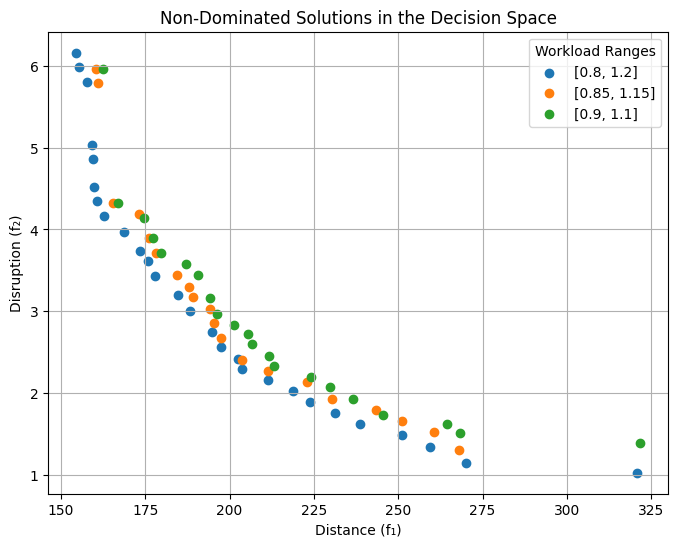

In [55]:
plot_decision_space(all_results)